In [1]:
# 📦 Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 🔁 Reproducibility
torch.manual_seed(0)

# 📌 Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📊 MNIST Dataset
transform = transforms.ToTensor()
train_loader = DataLoader(
    datasets.MNIST(root='./data', train=True, download=True, transform=transform),
    batch_size=128, shuffle=True
)

# 🧠 VAE Architecture
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc21 = nn.Linear(400, 20)  # μ
        self.fc22 = nn.Linear(400, 20)  # log(σ^2)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))  # sigmoid to constrain output [0,1]

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 500kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.75MB/s]


# Loss Functions

In [2]:
# VAE Loss (BCE or MSE reconstruction + KL divergence)
def vae_loss(recon_x, x, mu, logvar, mode='bce'):
    if mode == 'bce':
        recon_loss = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    elif mode == 'mse':
        recon_loss = F.mse_loss(recon_x, x.view(-1, 28*28), reduction='sum')
    else:
        raise ValueError("mode must be 'bce' or 'mse'")

    # KL Divergence
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl


# Training Function

In [3]:
def train_vae(mode='bce', epochs=10):
    model = VAE().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for batch, _ in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(batch)
            loss = vae_loss(recon_batch, batch, mu, logvar, mode)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader.dataset)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - {mode.upper()} Loss: {avg_loss:.4f}")
    return model, loss_history


# Compare Loss Curves

Epoch 1/20 - BCE Loss: 164.2581
Epoch 2/20 - BCE Loss: 121.1992
Epoch 3/20 - BCE Loss: 114.3877
Epoch 4/20 - BCE Loss: 111.5787
Epoch 5/20 - BCE Loss: 109.7606
Epoch 6/20 - BCE Loss: 108.6465
Epoch 7/20 - BCE Loss: 107.8419
Epoch 8/20 - BCE Loss: 107.1715
Epoch 9/20 - BCE Loss: 106.6572
Epoch 10/20 - BCE Loss: 106.2732
Epoch 11/20 - BCE Loss: 105.9334
Epoch 12/20 - BCE Loss: 105.6973
Epoch 13/20 - BCE Loss: 105.4088
Epoch 14/20 - BCE Loss: 105.1298
Epoch 15/20 - BCE Loss: 104.9333
Epoch 16/20 - BCE Loss: 104.7667
Epoch 17/20 - BCE Loss: 104.6096
Epoch 18/20 - BCE Loss: 104.4534
Epoch 19/20 - BCE Loss: 104.2952
Epoch 20/20 - BCE Loss: 104.1737
Epoch 1/20 - MSE Loss: 45.5432
Epoch 2/20 - MSE Loss: 35.3343
Epoch 3/20 - MSE Loss: 33.3835
Epoch 4/20 - MSE Loss: 32.4682
Epoch 5/20 - MSE Loss: 31.8975
Epoch 6/20 - MSE Loss: 31.5093
Epoch 7/20 - MSE Loss: 31.2526
Epoch 8/20 - MSE Loss: 31.0085
Epoch 9/20 - MSE Loss: 30.8262
Epoch 10/20 - MSE Loss: 30.6740
Epoch 11/20 - MSE Loss: 30.5626
Epoch 

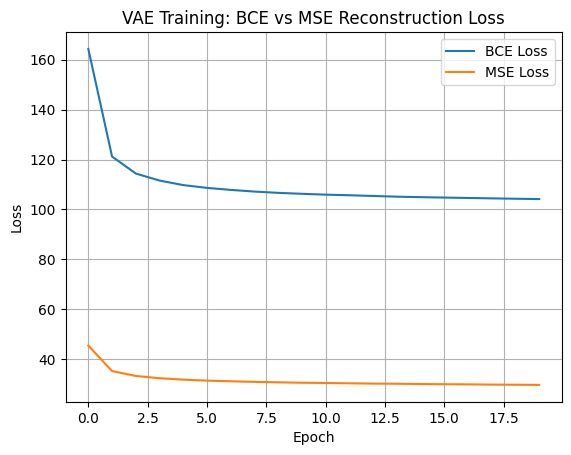

In [4]:
# Train both models
vae_bce, bce_losses = train_vae(mode='bce', epochs=20)
vae_mse, mse_losses = train_vae(mode='mse', epochs=20)

# Plotting
plt.plot(bce_losses, label='BCE Loss')
plt.plot(mse_losses, label='MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training: BCE vs MSE Reconstruction Loss')
plt.legend()
plt.grid(True)
plt.show()


# Visualize Reconstructions

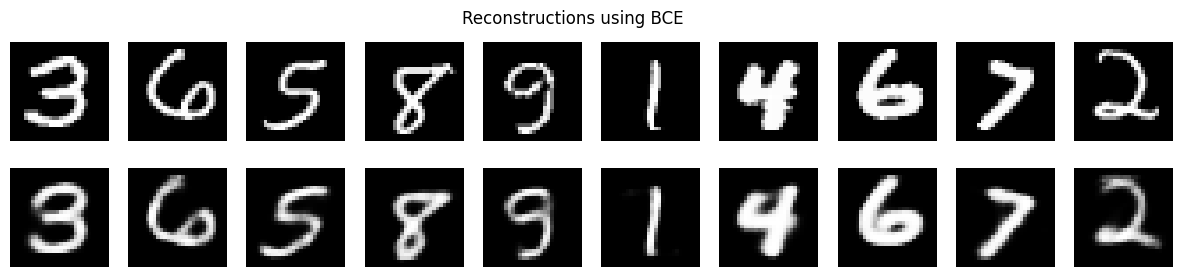

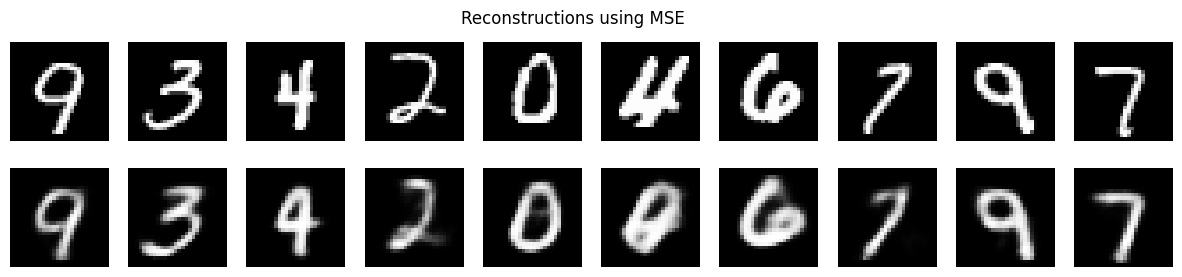

In [5]:
def show_reconstruction(model, mode='bce'):
    model.eval()
    test_batch, _ = next(iter(train_loader))
    test_batch = test_batch.to(device)
    with torch.no_grad():
        recon, _, _ = model(test_batch)

    recon = recon.view(-1, 1, 28, 28).cpu()
    fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        axes[0, i].imshow(test_batch[i][0].cpu(), cmap='gray')
        axes[1, i].imshow(recon[i][0], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].axis('off')
    fig.suptitle(f'Reconstructions using {mode.upper()}')
    plt.show()

show_reconstruction(vae_bce, mode='bce')
show_reconstruction(vae_mse, mode='mse')
